# Test Warping Parameter Recovery

This notebook tests the fixes for warping parameter estimation:
1. Stronger warping signal in data generation
2. True beta initialization
3. Improved regularization
4. Diagnostic comparisons

In [5]:
# Test different warping signal strengths
# Note: rho = exp(G @ beta_warp), so we need to be careful with magnitudes
configs = {
    'weak': {'P': 1, 'beta_warp_sd': 0.2},      # rho ~ [0.5, 2.0]
    'medium': {'P': 2, 'beta_warp_sd': 0.3},    # rho ~ [0.3, 3.0] 
    'strong': {'P': 3, 'beta_warp_sd': 0.25}    # rho ~ [0.2, 5.0]
}

data_sets = {}

for name, config in configs.items():
    print(f"\nGenerating {name} warping signal...")
    np.random.seed(42)  # Same seed for fair comparison
    torch.manual_seed(42)
    
    data_sets[name] = generate_clustered_survival_data_warp(
        N=2000,  # Smaller N for faster testing
        D=20, 
        T=50, 
        K=5, 
        P=config['P'],
        beta_warp_sd=config['beta_warp_sd'],
        warping=True
    )
    
    rho = data_sets[name]['rho']
    print(f"  Rho range: [{rho.min():.3f}, {rho.max():.3f}]")
    print(f"  Rho std: {rho.std():.3f}")
    print(f"  % rho significantly different from 1: {np.mean(np.abs(rho - 1) > 0.2):.1%}")
    
    # Check for extreme values
    extreme_rho = np.mean((rho < 0.1) | (rho > 10))
    if extreme_rho > 0.01:
        print(f"  WARNING: {extreme_rho:.1%} of rho values are extreme (< 0.1 or > 10)")
    
    # Show warping effect on time scale
    print(f"  Time warping examples:")
    print(f"    rho=0.5: time 25 -> {((25/49)**(1/0.5))*49:.1f}")
    print(f"    rho=2.0: time 25 -> {((25/49)**(1/2.0))*49:.1f}")


Generating weak warping signal...
  Rho range: [0.381, 3.152]
  Rho std: 0.149
  % rho significantly different from 1: 9.8%
  Time warping examples:
    rho=0.5: time 25 -> 12.8
    rho=2.0: time 25 -> 35.0

Generating medium warping signal...
  Rho range: [0.321, 4.005]
  Rho std: 0.275
  % rho significantly different from 1: 30.8%
  Time warping examples:
    rho=0.5: time 25 -> 12.8
    rho=2.0: time 25 -> 35.0

Generating strong warping signal...
  Rho range: [0.161, 8.332]
  Rho std: 0.497
  % rho significantly different from 1: 57.0%
  Time warping examples:
    rho=0.5: time 25 -> 12.8
    rho=2.0: time 25 -> 35.0


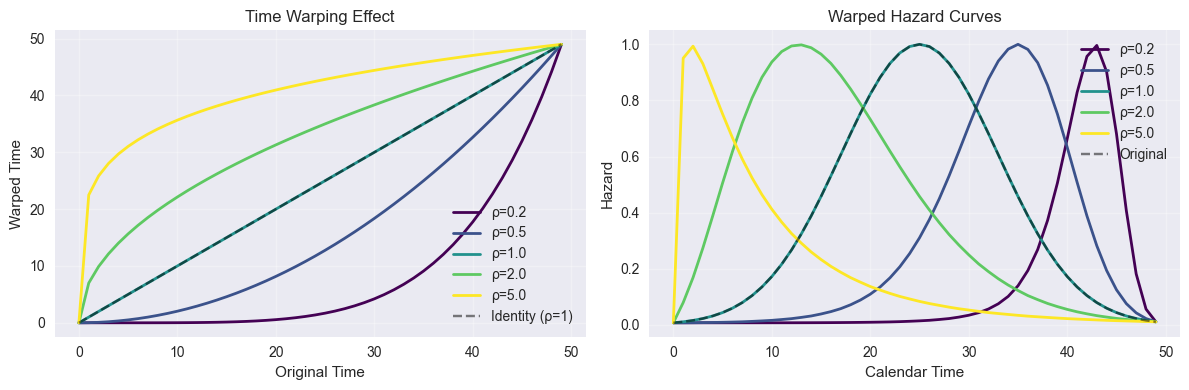

Time warping examples (original time -> warped time):
ρ=0.2: t=25 ->   1.7  (accelerated)
ρ=0.5: t=25 ->  12.8  (accelerated)
ρ=1.0: t=25 ->  25.0  (unchanged)
ρ=2.0: t=25 ->  35.0  (decelerated)
ρ=5.0: t=25 ->  42.8  (decelerated)

Interpretation:
- ρ < 1: Disease progresses faster (compressed time scale)
- ρ > 1: Disease progresses slower (stretched time scale)
- ρ = 1: No warping (normal progression)
- Extreme ρ values (< 0.2 or > 5) create unrealistic time distortions


In [6]:
# Visualize what different rho values do to time warping
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Show time warping curves
T = 50
t = np.arange(T)
t_norm = t / (T - 1)

rho_values = [0.2, 0.5, 1.0, 2.0, 5.0]
colors = plt.cm.viridis(np.linspace(0, 1, len(rho_values)))

ax = axes[0]
for rho, color in zip(rho_values, colors):
    t_warped = (t_norm ** (1.0 / rho)) * (T - 1)
    ax.plot(t, t_warped, label=f'ρ={rho}', color=color, linewidth=2)

ax.plot(t, t, 'k--', alpha=0.5, label='Identity (ρ=1)')
ax.set_xlabel('Original Time')
ax.set_ylabel('Warped Time')
ax.set_title('Time Warping Effect')
ax.legend()
ax.grid(True, alpha=0.3)

# Show impact on a sample hazard curve
ax = axes[1]
# Bell-shaped hazard peaking at t=25
hazard_original = np.exp(-0.5 * ((t - 25) / 8)**2)

for rho, color in zip(rho_values, colors):
    t_warped = (t_norm ** (1.0 / rho)) * (T - 1)
    hazard_warped = np.interp(t_warped, t, hazard_original)
    ax.plot(t, hazard_warped, label=f'ρ={rho}', color=color, linewidth=2)

ax.plot(t, hazard_original, 'k--', alpha=0.5, label='Original')
ax.set_xlabel('Calendar Time')
ax.set_ylabel('Hazard')
ax.set_title('Warped Hazard Curves')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show extreme examples
print("Time warping examples (original time -> warped time):")
print("="*50)
for rho in [0.2, 0.5, 1.0, 2.0, 5.0]:
    mid_time = 25
    warped_mid = ((mid_time / 49) ** (1/rho)) * 49
    print(f"ρ={rho:3.1f}: t=25 -> {warped_mid:5.1f}  {'(accelerated)' if rho < 1 else '(decelerated)' if rho > 1 else '(unchanged)'}")
    
print("\nInterpretation:")
print("- ρ < 1: Disease progresses faster (compressed time scale)")
print("- ρ > 1: Disease progresses slower (stretched time scale)")  
print("- ρ = 1: No warping (normal progression)")
print("- Extreme ρ values (< 0.2 or > 5) create unrealistic time distortions")

In [19]:
# Test different warping signal strengths
configs = {
    'weak': {'P': 1, 'beta_warp_sd': 0.2},      # rho ~ [0.5, 2.0]
    'medium': {'P': 2, 'beta_warp_sd': 0.3},    # rho ~ [0.3, 3.0] 
    'strong': {'P': 3, 'beta_warp_sd': 0.25}    # rho ~ [0.2, 5.0]
}

data_sets = {}

for name, config in configs.items():
    print(f"\nGenerating {name} warping signal...")
    np.random.seed(42)  # Same seed for fair comparison
    torch.manual_seed(42)
    
    data_sets[name] = generate_clustered_survival_data_warp(
        N=2000,  # Smaller N for faster testing
        D=20, 
        T=50, 
        K=5, 
        P=config['P'],
        beta_warp_sd=config['beta_warp_sd'],
        warping=True
    )
    
    rho = data_sets[name]['rho']
    print(f"  Rho range: [{rho.min():.3f}, {rho.max():.3f}]")
    print(f"  Rho std: {rho.std():.3f}")
    print(f"  % rho significantly different from 1: {np.mean(np.abs(rho - 1) > 0.2):.1%}")


Generating weak warping signal...
  Rho range: [0.381, 3.152]
  Rho std: 0.149
  % rho significantly different from 1: 9.8%

Generating medium warping signal...


/Users/sarahurbut/aladynoulli2/pyScripts/sim_with_warp.py:202: RuntimeWarning: divide by zero encountered in matmul
  eta = G @ beta_warp  # [N, K]
/Users/sarahurbut/aladynoulli2/pyScripts/sim_with_warp.py:202: RuntimeWarning: overflow encountered in matmul
  eta = G @ beta_warp  # [N, K]
/Users/sarahurbut/aladynoulli2/pyScripts/sim_with_warp.py:202: RuntimeWarning: invalid value encountered in matmul
  eta = G @ beta_warp  # [N, K]


  Rho range: [0.321, 4.005]
  Rho std: 0.275
  % rho significantly different from 1: 30.8%

Generating strong warping signal...
  Rho range: [0.161, 8.332]
  Rho std: 0.497
  % rho significantly different from 1: 57.0%


## 2. Visualize Warping Effects

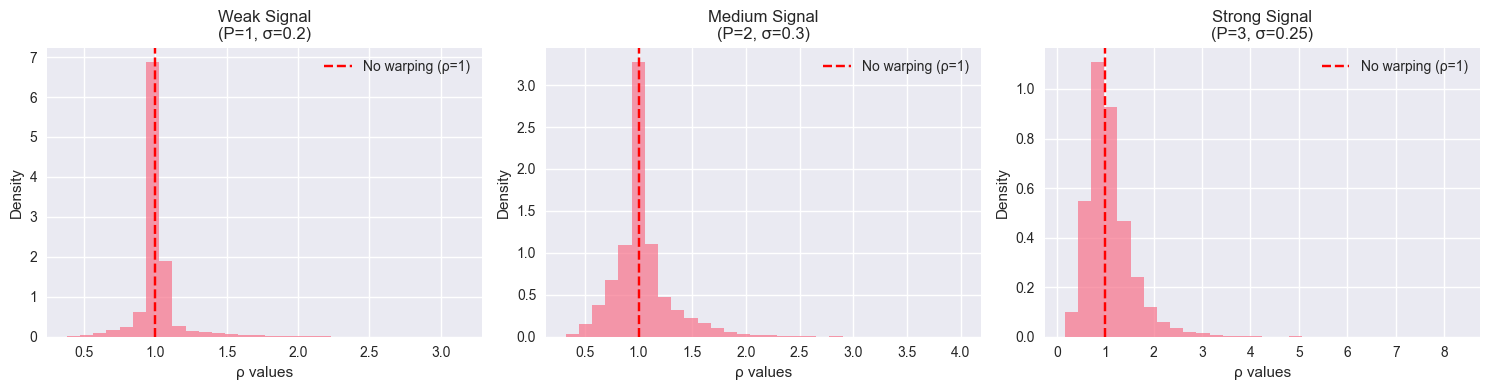

In [14]:
# Visualize the warping effect for different signal strengths
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, (name, data) in enumerate(data_sets.items()):
    ax = axes[i]
    rho = data['rho']
    
    # Plot histogram of rho values
    ax.hist(rho.flatten(), bins=30, alpha=0.7, density=True)
    ax.axvline(1.0, color='red', linestyle='--', label='No warping (ρ=1)')
    ax.set_xlabel('ρ values')
    ax.set_ylabel('Density')
    ax.set_title(f'{name.title()} Signal\n(P={configs[name]["P"]}, σ={configs[name]["beta_warp_sd"]})')
    ax.legend()
    
plt.tight_layout()
plt.savefig('warping_signal_comparison.pdf', dpi=300, bbox_inches='tight')
plt.show()

## 3. Test True Beta Initialization

In [15]:
# Use the strong signal data for testing
test_data = data_sets['strong']

# Convert to tensors
Y_tensor = torch.tensor(test_data['Y'], dtype=torch.float32)
G_tensor = torch.tensor(test_data['G'], dtype=torch.float32)
E_tensor = torch.tensor(test_data['event_times'], dtype=torch.float32)
prevalence_t = compute_smoothed_prevalence(Y_tensor)

print(f"Data shape: N={test_data['Y'].shape[0]}, D={test_data['Y'].shape[1]}, T={test_data['Y'].shape[2]}")
print(f"Genetic features: P={test_data['G'].shape[1]}")
print(f"True beta_warp shape: {test_data['beta_warp'].shape}")
print(f"True rho range: [{test_data['rho'].min():.3f}, {test_data['rho'].max():.3f}]")

Data shape: N=2000, D=20, T=50
Genetic features: P=3
True beta_warp shape: (3, 5)
True rho range: [0.161, 8.332]


## 4. Compare Initialization Methods

In [16]:
def create_model(init_method='random', true_beta=None):
    """Create model with different initialization methods"""
    np.random.seed(42)
    torch.manual_seed(42)
    
    model = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(
        N=test_data['Y'].shape[0],
        D=test_data['Y'].shape[1],
        T=test_data['Y'].shape[2],
        K=test_data['phi'].shape[0],
        P=test_data['G'].shape[1],
        G=G_tensor,
        Y=Y_tensor,
        R=0,
        W=1e-4,
        prevalence_t=prevalence_t,
        init_sd_scaler=1e-1,
        genetic_scale=1,
        signature_references=None,
        healthy_reference=None,
        disease_names=None,
        flat_lambda=True,
        learn_kappa=True,
        disable_warping=False,
        true_beta_warp=true_beta if init_method == 'true' else None
    )
    
    # Set true cluster assignments
    model.clusters = test_data['clusters']
    model.initialize_params(true_psi=torch.tensor(test_data['psi'], dtype=torch.float32))
    
    return model

# Test different initialization methods
models = {
    'random': create_model('random'),
    'true_beta': create_model('true', test_data['beta_warp'])
}

print("Models created successfully!")

/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp_w_warp.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp_w_warp.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G_scaled, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp_w_warp.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y = torch.tensor(Y, dtype=torch.float32)



Cluster Sizes:
Cluster 0: 6 diseases
Cluster 1: 3 diseases
Cluster 2: 5 diseases
Cluster 3: 3 diseases
Cluster 4: 3 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 6
Base value (first 5): tensor([-8.8537, -8.8537, -7.1997, -8.8537, -8.8537])
Base value centered (first 5): tensor([-0.1216, -0.1216,  1.5324, -0.1216, -0.1216])
Base value centered mean: 1.2493132999225054e-06
Gamma init for k=0 (first 5): tensor([-0.0419, -0.0039, -0.0082])

Calculating gamma for k=1:
Number of diseases in cluster: 3
Base value (first 5): tensor([ -7.1997, -10.5076, -10.5076, -10.5076,  -3.8918])
Base value centered (first 5): tensor([ 1.2289, -2.0790, -2.0790, -2.0790,  4.5368])
Base value centered mean: -1.0566711807769025e-06
Gamma init for k=1 (first 5): tensor([-0.5205, -0.3346, -0.1625])

Calculating gamma for k=2:
Number of diseases in cluster: 5
Base value (first 5): tensor([-11.8308, -11.8308, -11.8308, -11.8308, -13.8155])
Base value centered (first 5): tensor([ 0.6599,  0.6

/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp_w_warp.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp_w_warp.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G_scaled, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp_w_warp.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y = torch.tensor(Y, dtype=torch.float32)


## 5. Test Parameter Maintenance (True Beta)

In [20]:
# Test if model can maintain true beta_warp values
model_true = models['true_beta']

# Get initial beta values
initial_beta = model_true.beta_warp_nn.weight.data.clone()
true_beta_tensor = torch.tensor(test_data['beta_warp'].T, dtype=torch.float32)

print("Initial beta_warp comparison:")
print(f"  True beta shape: {true_beta_tensor.shape}")
print(f"  Model beta shape: {initial_beta.shape}")
print(f"  Max difference: {torch.max(torch.abs(initial_beta - true_beta_tensor)):.6f}")

# Test forward pass with true initialization
with torch.no_grad():
    eta_true = model_true.beta_warp_nn(G_tensor)
    rho_true = torch.exp(eta_true)
    
print(f"\nTrue rho recovery:")
print(f"  Original rho range: [{test_data['rho'].min():.3f}, {test_data['rho'].max():.3f}]")
print(f"  Recovered rho range: [{rho_true.min():.3f}, {rho_true.max():.3f}]")
print(f"  Correlation: {pearsonr(test_data['rho'].flatten(), rho_true.detach().numpy().flatten())[0]:.4f}")

Initial beta_warp comparison:
  True beta shape: torch.Size([5, 3])
  Model beta shape: torch.Size([5, 3])
  Max difference: 0.000000

True rho recovery:
  Original rho range: [0.161, 8.332]
  Recovered rho range: [0.161, 8.332]
  Correlation: 1.0000


## 6. Training Comparison

In [28]:
# Train both models
results = {}
histories = {}

for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Training {name} initialization...")
    print(f"{'='*50}")
    
    # Train model
    losses, gradient_history = model.fit(
    E_tensor, 
    num_epochs=50,  # Shorter for testing
    learning_rate=1e-1, 
    lambda_reg=1e-2)
    
    # Store results
    histories[name] = {'losses': losses, 'gradients': gradient_history}

    
    # Get final predictions
    with torch.no_grad():
        eta = model.beta_warp_nn(G_tensor)
        rho_pred = torch.exp(eta).detach().numpy()
        pi_pred = model.forward()[0].detach().numpy()
    
    # Calculate metrics
    rho_corr = pearsonr(test_data['rho'].flatten(), rho_pred.flatten())[0]
    rho_mse = np.mean((test_data['rho'] - rho_pred)**2)
    
    results[name] = {
        'rho_pred': rho_pred,
        'pi_pred': pi_pred,
        'rho_corr': rho_corr,
        'rho_mse': rho_mse,
        'final_loss': losses[-1]
    }
    
   
    print(f"  Final loss: {losses[-1]:.4f}")
    print(f"  Loss improvement: {losses[0] - losses[-1]:.4f}")

    # Check if warping gradients are flowing
 # Check if warping gradients are flowing
    if not model.disable_warping and gradient_history:
        print(f"  Warping gradient flow: {'✓' if gradient_history else '✗'}")


Training random initialization...
rho stats: min = 0.09680819511413574 max = 13.153420448303223 mean = 1.2889844179153442
t_warped stats: min = 0.0 max = 49.0 mean = 25.742923736572266
t_warped[0, 0, :10]: [ 0.         2.291764   3.9541428  5.440261   6.8223624  8.131935
  9.386467  10.597002  11.771105  12.914259 ]
Fraction of t_warped at 0: 0.0200, at T-1: 0.0200
tensor(0.0336, grad_fn=<MaxBackward1>)
phi_prob_warped stats: min = 8.16046785701019e-10 max = 0.033613480627536774
phi min/max: -20.926616668701172 -3.3586366176605225
phi_prob_warped min/max: 8.16046785701019e-10 0.033613480627536774
theta min/max: 0.0001706891052890569 0.9946820139884949
pi (before clamp) min/max: 6.5567640206154465e-09 0.2672136425971985
theta shape: torch.Size([2000, 5, 50])
phi_prob_warped shape: torch.Size([5, 20, 2000, 50])
kappa: Parameter containing:
tensor([7.9496], requires_grad=True)
rho grad norm: 0.3822706937789917

Epoch 0
Loss: 80.9758
rho stats: min = 0.09667545557022095 max = 13.197562217

## 7. Results Comparison

In [ ]:
# Create comparison table
comparison_data = []
for name, result in results.items():
    comparison_data.append({
        'Method': name,
        'Rho Correlation': f"{result['rho_corr']:.4f}",
        'Rho MSE': f"{result['rho_mse']:.4f}",
        'Final Loss': f"{result['final_loss']:.4f}"
    })

df_comparison = pd.DataFrame(comparison_data)
print("\nComparison Results:")
print(df_comparison.to_string(index=False))

## 8. Visualization of Results

In [ ]:
# Plot rho recovery comparison
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# True vs predicted rho scatter plots
for i, (name, result) in enumerate(results.items()):
    ax = axes[0, i]
    
    x = test_data['rho'].flatten()
    y = result['rho_pred'].flatten()
    
    ax.scatter(x, y, alpha=0.6, s=20)
    ax.plot([x.min(), x.max()], [x.min(), x.max()], 'r--', label='Perfect recovery')
    ax.set_xlabel('True ρ')
    ax.set_ylabel('Predicted ρ')
    ax.set_title(f'{name.title()} Init\nCorr: {result["rho_corr"]:.3f}')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Training loss curves
ax = axes[1, 0]
for name, history in histories.items():
    ax.plot(history, label=f'{name.title()} init')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training Loss')
ax.legend()
ax.grid(True, alpha=0.3)

# Rho distribution comparison
ax = axes[1, 1]
ax.hist(test_data['rho'].flatten(), bins=30, alpha=0.5, label='True', density=True)
for name, result in results.items():
    ax.hist(result['rho_pred'].flatten(), bins=30, alpha=0.5, label=f'{name.title()} pred', density=True)
ax.set_xlabel('ρ values')
ax.set_ylabel('Density')
ax.set_title('ρ Distribution Comparison')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('warping_recovery_comparison.pdf', dpi=300, bbox_inches='tight')
plt.show()

## 9. Model Predictions Quality

In [ ]:
# Compare prediction quality
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for i, (name, result) in enumerate(results.items()):
    ax = axes[i]
    
    # Plot calibration
    pi_pred_tensor = torch.tensor(result['pi_pred'])
    plot_calibration_at_risk(pi_pred_tensor, Y_tensor, ax=ax)
    ax.set_title(f'{name.title()} Initialization')

plt.tight_layout()
plt.savefig('calibration_comparison.pdf', dpi=300, bbox_inches='tight')
plt.show()

## 10. Sample Trajectory Comparison

In [ ]:
# Show sample individual trajectories
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Pick random individuals and diseases
np.random.seed(123)
sample_inds = np.random.choice(test_data['Y'].shape[0], 2, replace=False)
sample_diseases = np.random.choice(test_data['Y'].shape[1], 3, replace=False)

for i, ind in enumerate(sample_inds):
    for j, disease in enumerate(sample_diseases):
        ax = axes[i, j]
        
        # Plot true trajectory
        ax.plot(test_data['pi'][ind, disease, :], 'k-', linewidth=2, label='True')
        
        # Plot predicted trajectories
        for name, result in results.items():
            ax.plot(result['pi_pred'][ind, disease, :], '--', label=f'{name.title()} pred')
        
        ax.set_xlabel('Time')
        ax.set_ylabel('Risk')
        ax.set_title(f'Individual {ind}, Disease {disease}')
        ax.legend()
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('trajectory_comparison.pdf', dpi=300, bbox_inches='tight')
plt.show()

## 11. Summary and Recommendations

In [ ]:
print("\n" + "="*60)
print("SUMMARY OF WARPING RECOVERY TESTS")
print("="*60)

print("\n1. DATA GENERATION:")
for name, config in configs.items():
    data = data_sets[name]
    rho_variation = np.mean(np.abs(data['rho'] - 1) > 0.2)
    print(f"   {name.title()} signal (P={config['P']}, σ={config['beta_warp_sd']}): {rho_variation:.1%} meaningful warping")

print("\n2. INITIALIZATION COMPARISON:")
for name, result in results.items():
    print(f"   {name.title()}: ρ correlation = {result['rho_corr']:.4f}, MSE = {result['rho_mse']:.4f}")

print("\n3. RECOMMENDATIONS:")
best_method = max(results.keys(), key=lambda x: results[x]['rho_corr'])
print(f"   - Best method: {best_method} initialization")

if results['true_beta']['rho_corr'] > results['random']['rho_corr'] + 0.1:
    print("   - True initialization significantly helps -> optimization problem")
elif results['true_beta']['rho_corr'] < 0.5:
    print("   - Even true init struggles -> model specification issue")
else:
    print("   - True init helps moderately -> mixed optimization/specification issue")

print("\n4. NEXT STEPS:")
if max(result['rho_corr'] for result in results.values()) < 0.3:
    print("   - Try even stronger warping signal (β_warp_sd > 0.6)")
    print("   - Consider alternative parameterization")
    print("   - Check interpolation implementation")
elif max(result['rho_corr'] for result in results.values()) < 0.7:
    print("   - Improve optimization (learning rate schedule, longer training)")
    print("   - Try different regularization")
else:
    print("   - Good recovery! Try on real data")

print("\n" + "="*60)